# Session 6 - Transfer Learning & Image Generator

First, if we are working with images, loading the entire data-set in a single python variable isn’t an option, and so we need a generator function.

Thus using the advantage of generator, we can iterate over each (or batches of) image(s) in the large data-set and train our neural net quite easily.
<br>
<br>
To create a rather large data set we will use __Image Augmentations__
<br> 
<br>
Image Augmentations techniques are methods of artificially increasing the variations of images in our data-set by using horizontal/vertical flips, rotations, variations in brightness of images, horizontal/vertical shifts etc.

In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [58]:
train_datagen=ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

test_datagen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies


We created a __ImageDataGenerator__ that will generate augmentated images.
<br>
The features above can be altered to change how images will created

__ImageDataGenerators__ are inbuilt in keras and help us to train our model. We just have to specify the path to our training data and it automatically sends the data for training, in batches. It makes the code much simpler.

## Data Requirement
The training data must be stored in a particular format in order to be fed into the network to train.
- There must be a main data folder
- Inside that data folder, there must be a folder for each class of data containing the corresponding images
- The names of the folders must be the names of their respective classes.

In [59]:
image_size = (128,128)
batch_size = 10

training_data_dir = r'C:\Users\Dor Nisim\Desktop\Teaching\project\Images\train'
validation_data_dir = r'C:\Users\Dor Nisim\Desktop\Teaching\project\Images\validation'

train_generator=train_datagen.flow_from_directory(training_data_dir,
                                                 target_size=image_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(
                                        validation_data_dir,
                                         target_size=image_size,
                                         color_mode='rgb',
                                        class_mode = "categorical")


Found 255 images belonging to 5 classes.
Found 75 images belonging to 5 classes.


Let's observe the images that were generated

In [33]:
x_batch, y_batch = next(train_generator)

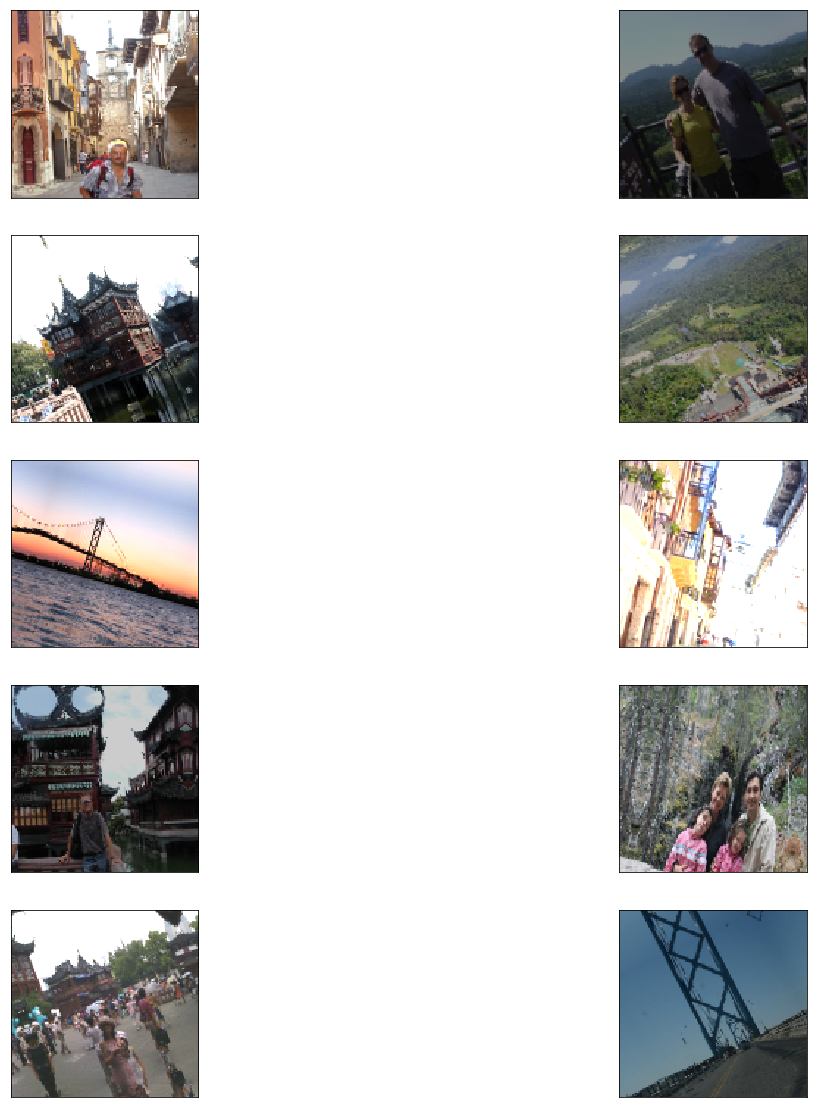

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = x_batch[i]
    image= image.astype(int)
    plt.imshow(image)


## Transfer Learning

We will use an existing network, to extract features from our images.
<br>
First, let us import the following libraries:

In [79]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

Let us consider the __VGG-16 model__ architecture, depicted in the figure below

<img src = "imgs/vgg16.png"/>

In [80]:
base_model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_size[0], image_size[1], 3))

We will import the network without the softmax layer

Let's see all the layers of the network

In [81]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

Let's see the names of the first 17 layers

In [82]:
for layer in base_model.layers[:17]:
    print(layer.name)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2


We would like to freeze the weights of the layers (Since the network is already trained rather well for feature extraction)

In [83]:
for layer in base_model.layers[:17]:
    layer.trainable = False

Now will add to the network dense layers in order to first classify the classes

In [84]:
classCount = 5

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(classCount,activation='softmax')(x) #final layer with softmax activation

model_final=Model(inputs=base_model.input,outputs=preds)
    

### Global Average Pooling

In the last few years, experts have turned to global average pooling (GAP) layers to minimize overfitting by reducing the total number of parameters in the model. Similar to max pooling layers, GAP layers are used to reduce the spatial dimensions of a three-dimensional tensor. However, GAP layers perform a more extreme type of dimensionality reduction, where a tensor with dimensions $h×w×d$ is reduced in size to have dimensions $1×1×d$. GAP layers reduce each $h×w$ feature map to a single number by simply taking the average of all $hw$ values.

<img src = "imgs/global_average_pooling.png"/>

Now, let us create the final network

In [85]:
# creating the final model 
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

Let us configure a loss function and optimizer

In [86]:
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

Let us first calculate the amount of batches in an ephoch (For fitting the model)

In [87]:
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)

25


We would like to observe the loss function values throught the training process.
<br>
This is why we create a callback to store the loss and accuracy function values:

In [88]:
class LossAccHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))
        
history = LossAccHistory()

Now let us train the model

In [70]:
model_final.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   epochs=5
                   ,callbacks = [history])

Epoch 1/5
 2/25 [=>............................] - ETA: 1:38 - loss: 3.2520 - acc: 0.1500

C:\Dor\ProgramFiles\envs\py36\lib\site-packages\PIL\Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


25/25 [==============================] - 98s 4s/step - loss: 1.4233 - acc: 0.5518 - val_loss: 0.5528 - val_acc: 0.7867
Epoch 2/5
25/25 [==============================] - 94s 4s/step - loss: 0.3311 - acc: 0.8839 - val_loss: 0.2479 - val_acc: 0.9067
Epoch 3/5
25/25 [==============================] - 96s 4s/step - loss: 0.2346 - acc: 0.9560 - val_loss: 0.1074 - val_acc: 0.9867
Epoch 4/5
25/25 [==============================] - 98s 4s/step - loss: 0.2220 - acc: 0.9440 - val_loss: 0.1290 - val_acc: 0.9333
Epoch 5/5
25/25 [==============================] - 95s 4s/step - loss: 0.0987 - acc: 0.9679 - val_loss: 0.0720 - val_acc: 0.9867


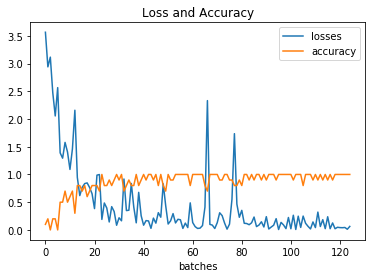

In [72]:
import matplotlib.pyplot as plt
x = range(0, len(history.losses))
plt.plot(x, history.losses)
plt.plot(x, history.accuracy)
plt.xlabel('batches')
plt.title('Loss and Accuracy')
plt.legend(['losses', 'accuracy'])

We can see that roughly around the 50 batches (third epoche) the model reached a high accuracy
<br>
We would like to stop the training phase early, and save the best model.

Thus, We can add the network an early stopping feature

In [92]:
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=1, mode='auto')

we wanted to monitor the test (validation) loss at each epoch and after the test loss has not improved after two epochs, training is interrupted. However, since we set __patience=2__, we won’t get the best model, but the model two epochs after the best model. 
<br>
<br>
Therefore, optionally, we can include a second operation, __ModelCheckpoint__ which saves the model to a file after every checkpoint (which can be useful in case a multi-day training session is interrupted for some reason. Helpful for us, if we set __save_best_only=True__ then __ModelCheckpoint__ will only save the best model.

We can even add a checkpoint that will store the best network that was trained

In [93]:
import time

networkfileName = "vgg16_{}.h5".format(int(time.time()))
checkpoint = ModelCheckpoint(networkfileName, monitor='val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

Let's re-train the network once more with the new features

In [94]:
history = LossAccHistory()
model_final.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   epochs=5
                   ,callbacks = [history, checkpoint, early])

Epoch 1/5
 4/25 [===>..........................] - ETA: 57s - loss: 0.3032 - acc: 0.9000

C:\Dor\ProgramFiles\envs\py36\lib\site-packages\PIL\Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


24/25 [===========================>..] - ETA: 2s - loss: 0.2435 - acc: 0.9250
Epoch 00001: val_acc improved from -inf to 0.93333, saving model to vgg16_1545552721.h5
25/25 [==============================] - 96s 4s/step - loss: 0.2429 - acc: 0.9239 - val_loss: 0.2320 - val_acc: 0.9333
Epoch 2/5
24/25 [===========================>..] - ETA: 2s - loss: 0.1619 - acc: 0.9417
Epoch 00002: val_acc improved from 0.93333 to 1.00000, saving model to vgg16_1545552721.h5
25/25 [==============================] - 93s 4s/step - loss: 0.1575 - acc: 0.9440 - val_loss: 0.1025 - val_acc: 1.0000
Epoch 3/5
24/25 [===========================>..] - ETA: 2s - loss: 0.1025 - acc: 0.9750
Epoch 00003: val_acc did not improve from 1.00000
25/25 [==============================] - 93s 4s/step - loss: 0.1021 - acc: 0.9760 - val_loss: 0.1288 - val_acc: 0.9600
Epoch 4/5
24/25 [===========================>..] - ETA: 2s - loss: 0.0945 - acc: 0.9792
Epoch 00004: val_acc did not improve from 1.00000
25/25 [===============

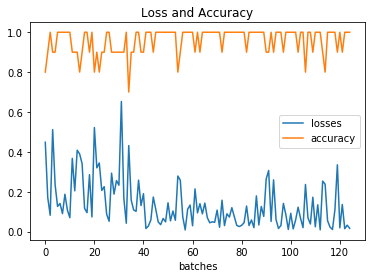

In [96]:
import matplotlib.pyplot as plt
x = range(0, len(history.losses))
plt.plot(x, history.losses)
plt.plot(x, history.accuracy)
plt.xlabel('batches')
plt.title('Loss and Accuracy')
plt.legend(['losses', 'accuracy'])

## Extract features

Now that we have created a trained network, we would like to extract the features for the images in the data set

In [148]:
from tensorflow.keras.models import load_model
import os

data_dir = r'C:\Users\Dor Nisim\Desktop\Teaching\project\Images\train'

base_model = load_model('vgg16_1545552721.h5')

x=base_model.get_layer('block5_pool').output
vector=Flatten()(x)

model = Model(inputs=base_model.input, outputs=vector)

datagen = ImageDataGenerator()     # Creating the Data generator
generator = datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),
        batch_size=1,
        class_mode='categorical',  # only data, no labels
        shuffle=False)  # keep data in same order as labels

Found 255 images belonging to 5 classes.


Let us process the images and store the labels and the original labels

In [149]:
import numpy as np

imgsList = []
proccImgs = []
labels = []
for i in range(generator.n):
    (img, lbl) = generator.next();
    imgsList.append(img)            # Adding the image to the list of images
    proccImgs.append(np.reshape(model.predict_on_batch(img), -1))
    labels.append(np.argmax(lbl))
    
print(labels)

C:\Dor\ProgramFiles\envs\py36\lib\site-packages\PIL\Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Now we will train a KNN Classifier that will choose the __k=4__ nearest neighbors

In [150]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=4)

neigh.fit(proccImgs, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

Now, we will take images from the test set and pre-process them

In [154]:
test_datagen = ImageDataGenerator()     # Creating the Data generator
validation_generator = test_datagen.flow_from_directory(
                                        validation_data_dir,
                                         target_size=(128, 128),
                                         batch_size=1,
                                         color_mode='rgb',
                                        class_mode = "categorical",
                                        shuffle=True)

features = model.predict_generator(validation_generator, 1)

Found 75 images belonging to 5 classes.


Now, let us classify the images and get the indexes of the most similar images

In [155]:
labels = neigh.kneighbors(features, return_distance=False) 

print(labels[0])

[143 117 115 151]


Let's display them!

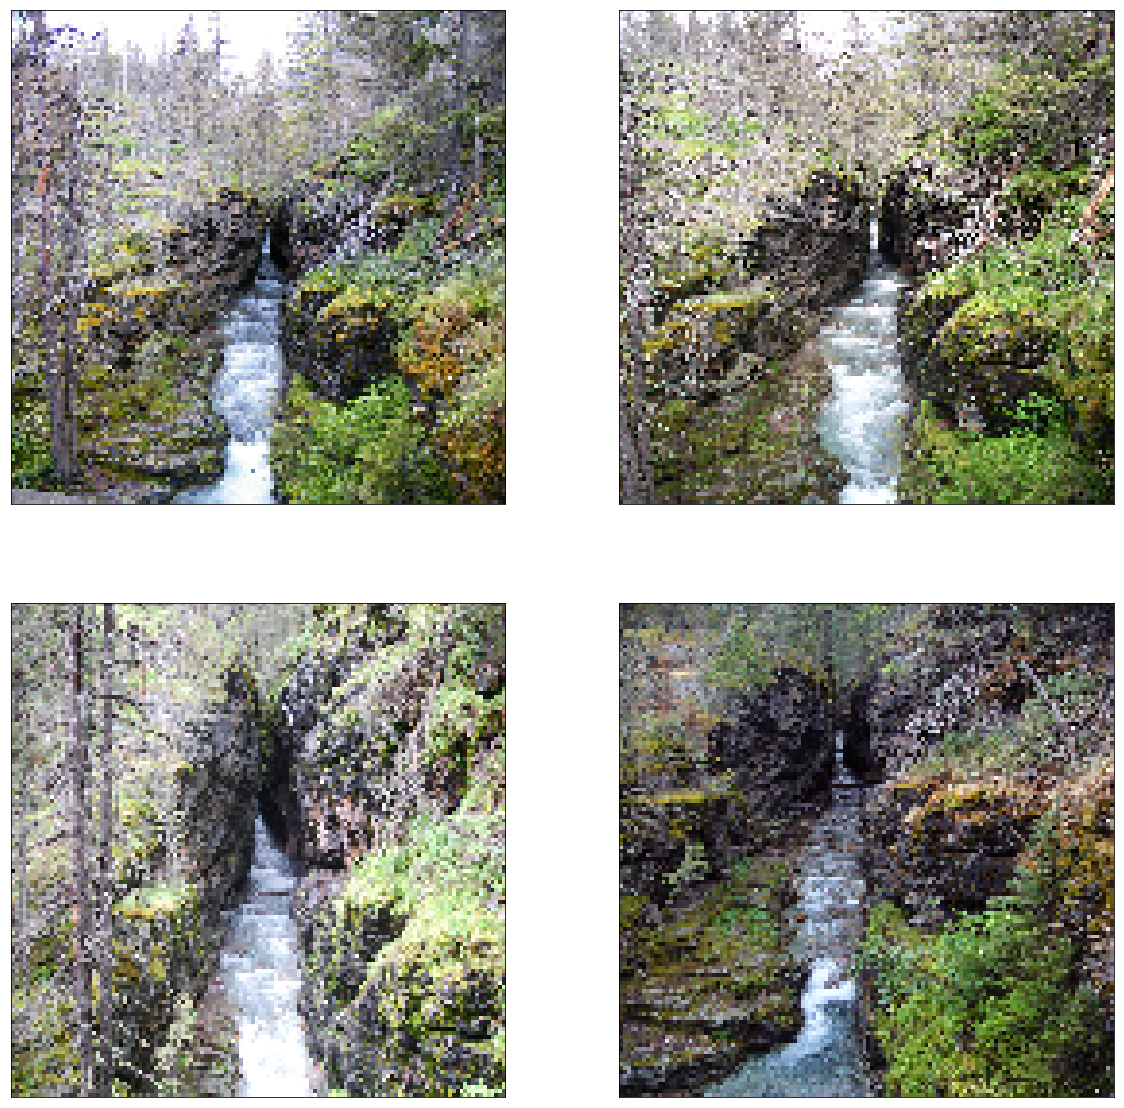

In [156]:
plt.figure(figsize=(20, 20))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = imgsList[labels[0][i]]
    image= image.astype(int)
    image = np.reshape(image, (128, 128, 3))
    plt.imshow(image)